## aggregation index (rome, number index, area fraction, area)

In [19]:
import xarray as xr

import numpy as np
import skimage.measure as skm

import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import os

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [20]:
model = 'GFDL-CM3'
experiment = 'historical'
folder = '/Users/cbla0002/Documents/data/cmip5/' + model

In [21]:
fileName = model + '_pr4_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)

In [22]:
ds

<xarray.Dataset>
Dimensions:   (time: 4, lat: 22, lon: 128)
Coordinates:
  * time      (time) object 1970-01-01 12:00:00 ... 1970-01-04 12:00:00
  * lat       (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 23.72 26.51 29.3
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    pr4_days  (time, lat, lon) float32 ...

In [23]:
fileName = model + '_pr_extreme_' + experiment + '.nc'
path = folder + '/' + fileName
ds_percentile = xr.open_dataset(path)

In [24]:
ds_percentile

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    pr_97    (time) float64 ...
    pr_99    (time) float64 ...
    pr_999   (time) float64 ...

In [25]:
historical = True
rcp85 = False

if historical:
    experiment = 'historical'
    period=slice('1970-01','1999-12')
    ensemble = 'r1i1p1'

    if model == 'GISS-E2-H':
        ensemble = 'r6i1p1'


if rcp85:
    experiment = 'rcp85'
    period=slice('2070-01','2099-12')

    if model == 'GISS-E2-H':
        ensemble = 'r2i1p1'

## convective objects properties

In [26]:
pr_day = ds.pr4_days.isel(time=0)
lat = pr_day.lat
lon = pr_day.lon
conv_threshold = ds_percentile.pr_97.mean(dim=('time'))

In [27]:
# label 8-connected (2-connectivity) objects
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2)


In [28]:
# objects that touch across lon=0, lon=360 boundary are the same object, array(lat, lon)
def connect_boundary(array):
    s = np.shape(array)
    for row in np.arange(0,s[0]):
        if array[row,0]>0 and array[row,-1]>0:
            array[array==array[row,0]] = min(array[row,0],array[row,-1])
            array[array==array[row,-1]] = min(array[row,0],array[row,-1])

In [29]:
connect_boundary(L)

/var/folders/w4/tbqrrpzx0bd8qgzdjj9dzv2dhl9fz3/T/ipykernel_11566/1646835175.py:30: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


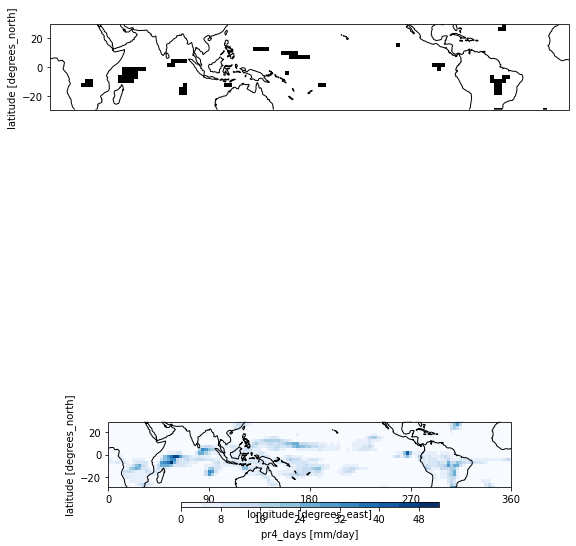

In [30]:
# plot objects in scene
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2)
connect_boundary(L)

O = pr_day.where(pr_day>=conv_threshold,0)>0
xr_L = xr.DataArray(L, coords={'lat': lat,'lon': lon})

projection = ccrs.PlateCarree(central_longitude=180)
f, (ax1, ax2) = plt.subplots(nrows = 2, subplot_kw=dict(projection=projection), figsize=(15, 7))

# objects binary
O.plot(ax=ax1, transform=ccrs.PlateCarree(), levels =4, colors = ['w','c','k'], add_colorbar=False) 
ax1.add_feature(cfeat.COASTLINE)
ax1.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
ax1.set_title('') #Snapshot of objects, model:' + model + ' exp:' + experiment)
#ax1.set_xticks([-180, -90, 0, 90, 180])
#ax1.set_xticklabels([0, 90, 180, 270, 360])
ax1.set_yticks([-20, 0, 20])
plt.tight_layout()

# objects labeled
pr_day.plot(ax=ax2, transform=ccrs.PlateCarree(), levels =len(np.unique(L)),cmap='Blues',cbar_kwargs={'orientation': 'horizontal','pad':0.175, 'aspect':55,'fraction':0.055})#,add_colorbar=False)
ax2.add_feature(cfeat.COASTLINE)
ax2.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
ax2.set_title('') #Snapshot of objects, model:' + model + ' exp:' + experiment)
ax2.set_xticks([-180, -90, 0, 90, 180])
ax2.set_xticklabels([0, 90, 180, 270, 360])
ax2.set_yticks([-20, 0, 20])

plt.tight_layout()


save = False
if save:
    plt.savefig('/home/565/cb4968/Documents/phd/both.pdf') 

In [31]:
# each object has a unique label
labels = np.unique(L)[1:]

In [33]:
# Calculate area, and precipitation of objects 
# This loses index of objects as in L

#create 3d matrix with each object being a binary 2d slice
obj3d = np.stack([(L==label) for label in labels],axis=2)*1

# object properties (python automatically broadcasts)
R = 6371 #km

pr_day = ds.pr4_days.isel(time=0)
pr_day = np.expand_dims(pr_day,axis=2)

lonm, latm = np.meshgrid(lon, lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

latm = np.expand_dims(latm,axis=2)
lonm = np.expand_dims(lonm,axis=2)
aream = np.expand_dims(aream,axis=2)


o_pr = xr.DataArray(np.sum(obj3d * pr_day * aream, axis=(0,1)) / np.sum(obj3d*aream, axis=(0,1)), attrs=dict(description="area weighted mean pr in object", units="mm/day"))
o_area = xr.DataArray(np.sum(obj3d * aream, axis=(0,1)), attrs=dict(description="area of object", units="km$^2$"))
                                                                           

In [34]:
o_area

<xarray.DataArray (dim_0: 15)>
array([ 169251.97805239,   84625.9890262 ,  466319.92944535,
       1232550.47127691,  475431.01125242,  189440.47633393,
        189440.47633393, 1833366.03003652,   96782.87117449,
        388051.84548862,  581157.40744228,  864156.77710563,
        378880.95266786,   93580.67721021,  258301.67645397])
Dimensions without coordinates: dim_0
Attributes:
    description:  area of object
    units:        km$^2$

## aggregation index

### number index

In [35]:
# Number of object in the scene
scene_oNumber = len(labels)

### area fraction

In [36]:
# areaweighting
weights = np.cos(np.deg2rad(lat))
weights.name = "weights"

In [39]:
ds

<xarray.Dataset>
Dimensions:   (time: 4, lat: 22, lon: 128)
Coordinates:
  * time      (time) object 1970-01-01 12:00:00 ... 1970-01-04 12:00:00
  * lat       (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 23.72 26.51 29.3
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    pr4_days  (time, lat, lon) float32 0.3183 0.2326 ... 4.32e-07 2.31e-06

In [43]:
conv_day = (pr_day.where(pr_day>=conv_threshold,0)>0)*1
scene_areaf = conv_day.weighted(weights).mean(dim=('lat','lon'))

In [44]:
np.float64(scene_areaf)

0.028038016067185575

### ROME

# saving

In [56]:
# object properties
save = False
if save:
    fileName = model + '_pr_objects_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)

    xr.Dataset({'o_lat': o_lat, 'o_lon': o_lon, 'o_pr': o_pr, 'o_area': o_area}).to_netcdf(path) 

In [58]:
# aggregation index
save = False
if save:
    fileName = model + '_pr_aggScene_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)

    xr.Dataset({'scene_oNumber': scene_oNumber, 'ROME': ROME, 'ROME_n': ROME_n, 'scene_areaf': scene_areaf}).to_netcdf(path) 